⚠️ Aviso: 'pt_BR.UTF-8' não disponível no Colab. Usando localidade padrão.


Saving 25.04.22.Dados.xlsx to 25.04.22.Dados.xlsx
📌 Colunas encontradas no Excel: ['Timestamp', 'Camisetas_básicas_masculinas']
Colunas disponíveis: ['data', 'camisetas_básicas_masculinas']
Sugestão: Renomear a coluna 'camisetas_básicas_masculinas' para 'vendas'


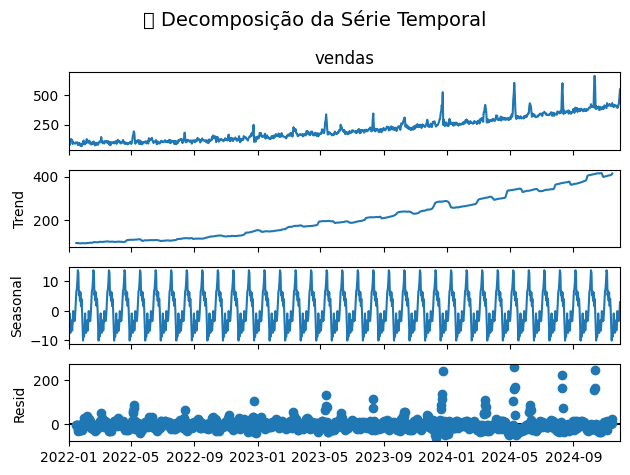


📅 Previsão diária para Dezembro de 2024:
    dia dia_da_semana  vendas_previstas  media_historica_vendas
0     1        Sunday             512.0              259.500000
1     2        Monday             487.0              201.500000
2     3       Tuesday             471.0              201.500000
3     4     Wednesday             466.0              201.500000
4     5      Thursday             460.0              201.500000
5     6        Friday             450.0              201.500000
6     7      Saturday             447.0              201.500000
7     8        Sunday             442.0              201.500000
8     9        Monday             444.0              194.500000
9    10       Tuesday             441.0              194.500000
10   11     Wednesday             441.0              194.500000
11   12      Thursday             436.0              194.500000
12   13        Friday             424.0              194.500000
13   14      Saturday             420.0              194.50000

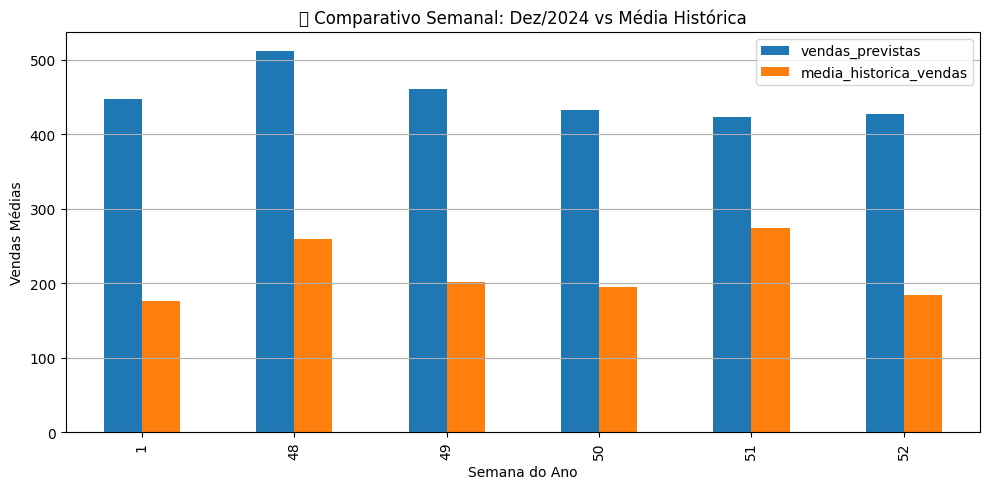

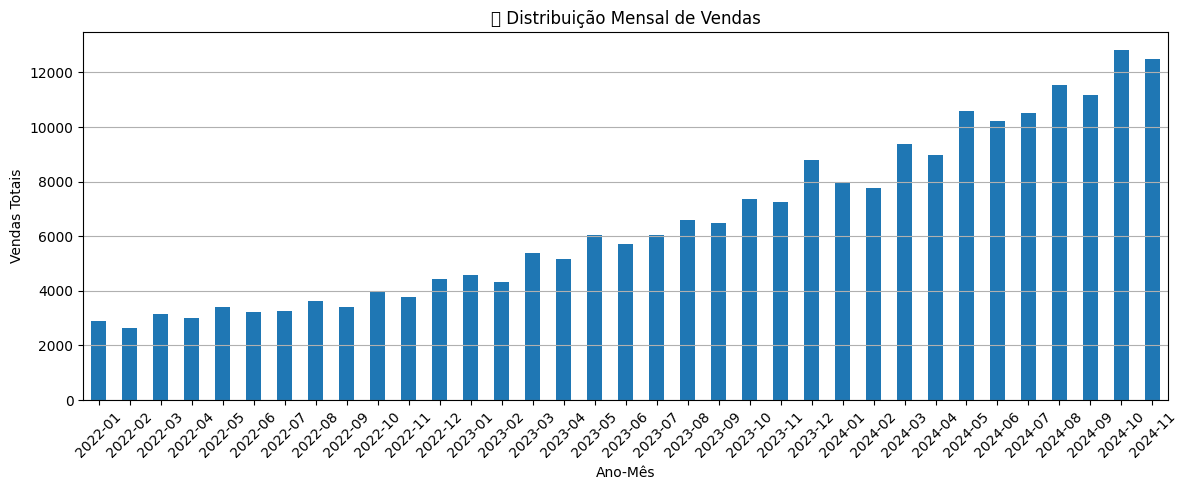

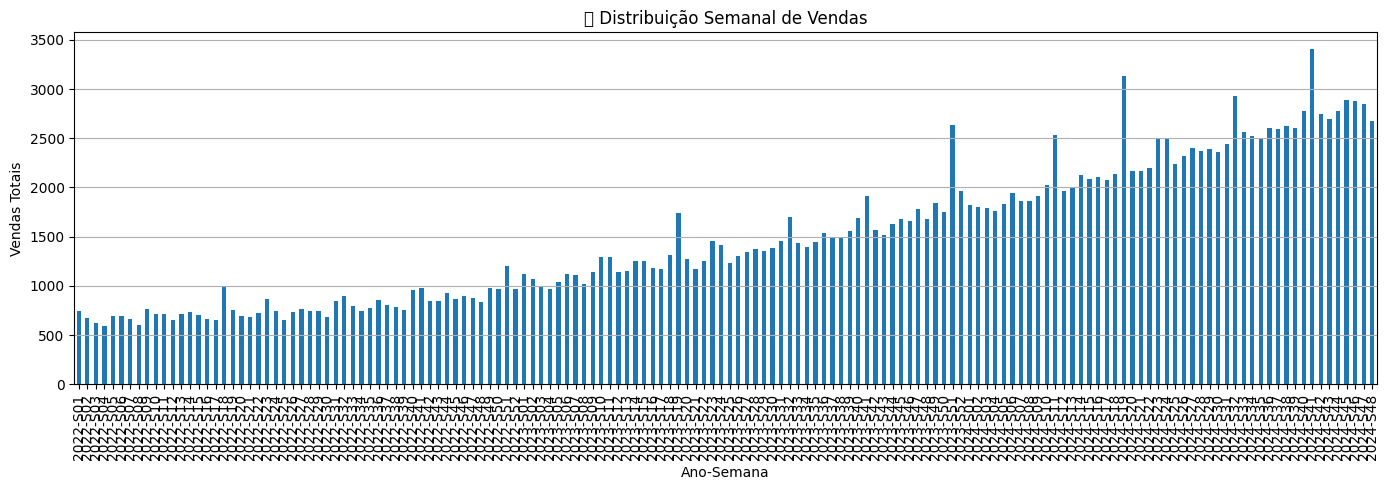

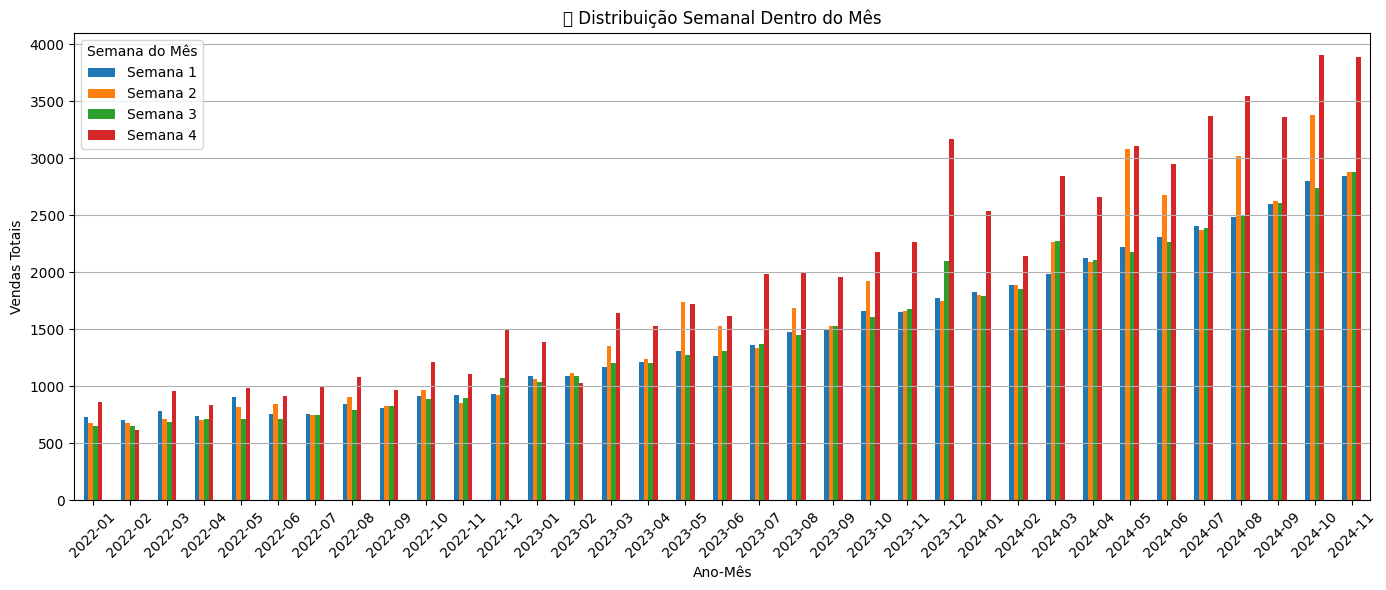

<Figure size 1200x600 with 0 Axes>

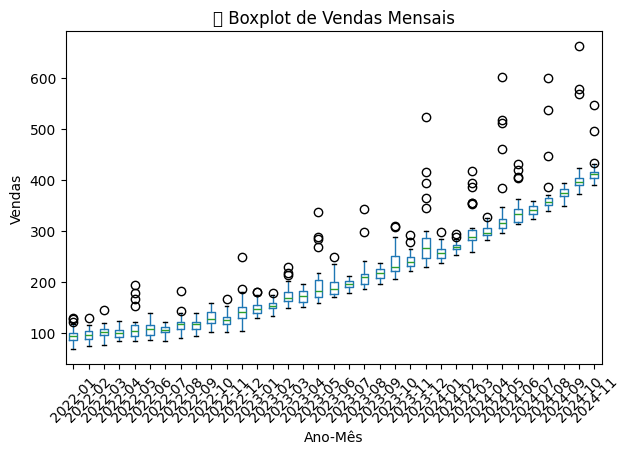

<Figure size 1200x600 with 0 Axes>

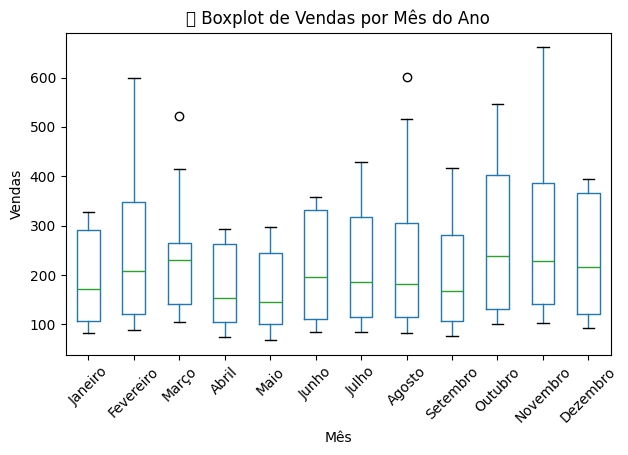

<Figure size 1400x600 with 0 Axes>

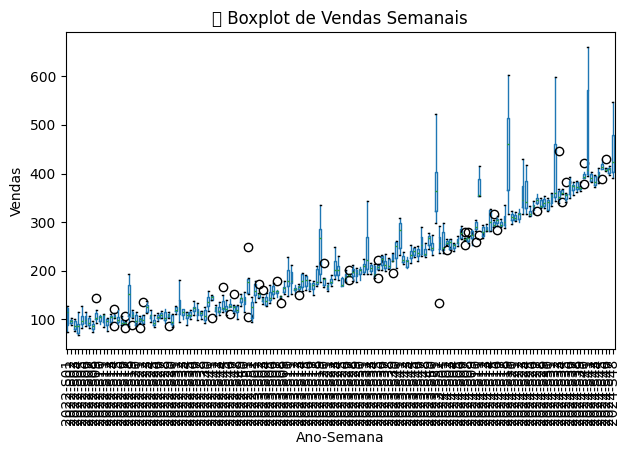

<Figure size 1000x600 with 0 Axes>

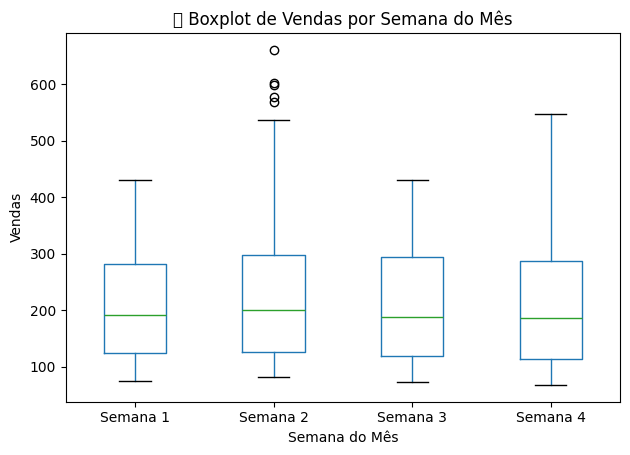

In [1]:
# ✅ Instalar pacotes necessários
!pip install pandas numpy matplotlib statsmodels openpyxl --quiet

# ✅ Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import locale
from google.colab import files

# ✅ Configuração de ambiente
warnings.filterwarnings('ignore')

try:
    locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')
except locale.Error:
    locale.setlocale(locale.LC_TIME, '')
    print("⚠️ Aviso: 'pt_BR.UTF-8' não disponível no Colab. Usando localidade padrão.")

# ✅ Upload do arquivo Excel
uploaded = files.upload()
arquivo = list(uploaded.keys())[0]

# ✅ Leitura e pré-processamento dos dados
df = pd.read_excel(arquivo)
print("📌 Colunas encontradas no Excel:", df.columns.tolist())
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

if 'timestamp' not in df.columns:
    raise KeyError("❌ A coluna 'timestamp' não foi encontrada no Excel.")
df.rename(columns={'timestamp': 'data'}, inplace=True)

col_vendas = [col for col in df.columns if any(keyword in col for keyword in ['venda', 'vendas'])]
if not col_vendas:
    print("Colunas disponíveis:", df.columns.tolist())
    coluna_sugerida = df.columns[1]
    print(f"Sugestão: Renomear a coluna '{coluna_sugerida}' para 'vendas'")
    df.rename(columns={coluna_sugerida: 'vendas'}, inplace=True)
else:
    df.rename(columns={col_vendas[0]: 'vendas'}, inplace=True)

df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data').set_index('data')

df['ano'] = df.index.year
df['mes'] = df.index.month
df['semana'] = df.index.isocalendar().week

# ✅ Decomposição da série temporal
%matplotlib inline
decomp = seasonal_decompose(df['vendas'], model='additive', period=30)
decomp.plot()
plt.suptitle('🔍 Decomposição da Série Temporal', fontsize=14)
plt.tight_layout()
plt.show()

# ✅ Modelo SARIMA
modelo = SARIMAX(df['vendas'], order=(1,1,1), seasonal_order=(1,1,1,30))
resultado = modelo.fit()

# ✅ Previsão para Dezembro/2024
inicio_prev = '2024-12-01'
fim_prev = '2024-12-31'
previsao = resultado.get_prediction(start=inicio_prev, end=fim_prev)
prev_df = previsao.summary_frame()[['mean']].rename(columns={'mean': 'vendas_previstas'})
prev_df['vendas_previstas'] = prev_df['vendas_previstas'].round(0)

prev_df['semana'] = prev_df.index.isocalendar().week
prev_df['dia'] = prev_df.index.day
prev_df['dia_da_semana'] = prev_df.index.strftime('%A')
prev_df['ano'] = prev_df.index.year

# ✅ Médias semanais históricas
df_treino = df[df.index < '2024-12-01']
media_semanal_hist = (
    df_treino.groupby('semana')['vendas']
    .mean()
    .reset_index()
    .rename(columns={'vendas': 'media_historica_vendas'})
)

# ✅ Junta previsão com histórico semanal
prev_df = prev_df.merge(media_semanal_hist, on='semana', how='left')

# ✅ Exibe tabela final
print("\n📅 Previsão diária para Dezembro de 2024:")
print(prev_df[['dia', 'dia_da_semana', 'vendas_previstas', 'media_historica_vendas']])

# ✅ Cálculo das métricas de erro
prev_df['erro'] = prev_df['vendas_previstas'] - prev_df['media_historica_vendas']
prev_df['erro_absoluto'] = prev_df['erro'].abs()
prev_df['erro_quadrado'] = prev_df['erro'] ** 2

dm = prev_df['erro'].mean()
mad = prev_df['erro_absoluto'].mean()
mse = prev_df['erro_quadrado'].mean()
rmse = np.sqrt(mse)
made = mad

metricas_df = pd.DataFrame({
    'Métrica': ['DM', 'MAD', 'MSE', 'RMSE', 'MADE'],
    'Valor': [dm, mad, mse, rmse, made]
})

print("\n📐 Métricas de Avaliação da Previsão:")
print(metricas_df.to_string(index=False))

# ✅ Gráfico comparativo por semana
agrupado = prev_df.groupby('semana')[['vendas_previstas', 'media_historica_vendas']].mean()
agrupado.plot(kind='bar', figsize=(10,5))
plt.title('📊 Comparativo Semanal: Dez/2024 vs Média Histórica')
plt.xlabel('Semana do Ano')
plt.ylabel('Vendas Médias')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ✅ NOVO: Distribuição mensal de vendas (histórico)
vendas_mensal = df.groupby(['ano', 'mes'])['vendas'].sum().reset_index()
vendas_mensal['ano_mes'] = vendas_mensal['ano'].astype(str) + '-' + vendas_mensal['mes'].astype(str).str.zfill(2)
vendas_mensal.plot(x='ano_mes', y='vendas', kind='bar', figsize=(12,5), legend=False)
plt.title('📅 Distribuição Mensal de Vendas')
plt.xlabel('Ano-Mês')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ✅ NOVO: Distribuição semanal de vendas (histórico)
vendas_semanal = df.groupby(['ano', 'semana'])['vendas'].sum().reset_index()
vendas_semanal['ano_semana'] = vendas_semanal['ano'].astype(str) + '-S' + vendas_semanal['semana'].astype(str).str.zfill(2)
vendas_semanal.plot(x='ano_semana', y='vendas', kind='bar', figsize=(14,5), legend=False)
plt.title('📅 Distribuição Semanal de Vendas')
plt.xlabel('Ano-Semana')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ✅ NOVO: Semana dentro do mês
def semana_do_mes(dia):
    if dia <= 7:
        return 'Semana 1'
    elif dia <= 14:
        return 'Semana 2'
    elif dia <= 21:
        return 'Semana 3'
    else:
        return 'Semana 4'

df['semana_mes'] = df.index.day.map(semana_do_mes)

# ✅ Agrupamento por ano, mês e semana do mês
vendas_semana_mes = (
    df.groupby(['ano', 'mes', 'semana_mes'])['vendas']
    .sum()
    .reset_index()
    .sort_values(['ano', 'mes', 'semana_mes'])
)

# ✅ Criar coluna ano-mês para o eixo
vendas_semana_mes['ano_mes'] = vendas_semana_mes['ano'].astype(str) + '-' + vendas_semana_mes['mes'].astype(str).str.zfill(2)

# ✅ Pivotar para ter cada semana como uma barra separada
pivot = vendas_semana_mes.pivot_table(index='ano_mes', columns='semana_mes', values='vendas', fill_value=0)

# ✅ Plotar gráfico
pivot.plot(kind='bar', figsize=(14,6))
plt.title('📅 Distribuição Semanal Dentro do Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=45)
plt.legend(title='Semana do Mês')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ✅ Boxplot: Distribuição mensal de vendas
plt.figure(figsize=(12,6))
df['ano_mes'] = df['ano'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2)
df.boxplot(column='vendas', by='ano_mes', grid=False)
plt.title('📦 Boxplot de Vendas Mensais')
plt.suptitle('')
plt.xlabel('Ano-Mês')
plt.ylabel('Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Nomear os meses
meses_nome = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df['mes_nome'] = df['mes'].map(meses_nome)

# ✅ Boxplot: Distribuição das vendas pelos 12 meses do ano (com nomes)
plt.figure(figsize=(12,6))
order_meses = list(meses_nome.values())
df.boxplot(column='vendas', by='mes_nome', grid=False)
plt.title('📦 Boxplot de Vendas por Mês do Ano')
plt.suptitle('')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.xticks(ticks=np.arange(1,13), labels=order_meses, rotation=45)
plt.tight_layout()
plt.show()

# ✅ Boxplot: Distribuição semanal geral de vendas
df['ano_semana'] = df['ano'].astype(str) + '-S' + df['semana'].astype(str).str.zfill(2)
plt.figure(figsize=(14,6))
df.boxplot(column='vendas', by='ano_semana', grid=False)
plt.title('📦 Boxplot de Vendas Semanais')
plt.suptitle('')
plt.xlabel('Ano-Semana')
plt.ylabel('Vendas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ✅ Boxplot: Distribuição por semanas dentro do mês
plt.figure(figsize=(10,6))
df.boxplot(column='vendas', by='semana_mes', grid=False)
plt.title('📦 Boxplot de Vendas por Semana do Mês')
plt.suptitle('')
plt.xlabel('Semana do Mês')
plt.ylabel('Vendas')
plt.tight_layout()
plt.show()